In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ibm_db, ibm_db_dbi
%matplotlib inline

plt.style.use('seaborn-white')

# Imports for tree-based algorithms
import catboost as cb
import xgboost as xgb
import lightgbm as lbg
from sklearn.ensemble import RandomForestClassifier

# Imports for other ML algorithms
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Sklearn Imports for model evaluation
from sklearn.metrics import (plot_precision_recall_curve,
                             roc_auc_score,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             f1_score, recall_score, 
                             precision_score, cohen_kappa_score, 
                             accuracy_score)

# Import for spliting the dataset
from sklearn.model_selection import train_test_split

# For scaling the data
from sklearn.preprocessing import StandardScaler

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Connecting to IBM Db2 Database

In [6]:
dsn_hostname = "---" 
dsn_uid = "---"      
dsn_pwd = "---"      
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            
dsn_port = "50000"                
dsn_protocol = "TCPIP"          

dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  fwv77263 on host:  dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net


# About the Dataset


This dataset is about customer churn. Customer churn, also known as costumer attrition, is defined as the loss of custumers or clients by a company. The dataset contains 7043 observations and 21 columns. A description of each column is presented below.

&nbsp;



| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| customerID     | ID of a Costumer                                                                      |
| Gender         | The Gender of a costumer                                                              |
| SeniorCitizen  | Whether the customer is a senior citizen or not                                       |
| Partner        | Whether the customer has a partner or not (Yes, No)                                   |
| Dependents       | Whether the customer has dependents or not (Yes, No)                                  |
| tenure           | Number of months the customer has stayed with the company                             |                     
| PhoneService     | Whether the customer has a phone service or not (Yes, No)                             |
| MultipleLines    | Whether the customer has multiple lines or not (Yes, No, No phone service)            |
| InternetService  | Customer’s internet service provider (DSL, Fiber optic, No                            |
| OnlineSecurity   |   Whether the customer has online security or not (Yes, No, No internet service)      |                    | OnlineBackup     |   Whether the customer has online backup or not (Yes, No, No internet service)        |
| DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service)    |                     | TechSupport      |  Whether the customer has tech support or not (Yes, No, No internet service)                                                          |
| StreamingTV      | Whether the customer has streaming TV or not (Yes, No, No internet service)                                                           |
| StreamingMovies      | Whether the customer has streaming movies or not (Yes, No, No internet service)                                                           |
| Contract      |  The contract term of the customer (Month-to-month, One year, Two year)                                                          |
| PaperlessBilling      |  Whether the customer has paperless billing or not (Yes, No)                                                          |
| PaymentMethod      |  The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))                                                          |
| MonthlyCharges      |  The amount charged to the customer monthly                                                         |
| TotalCharges      |     The total amount charged to the customer                                                       |
| Churn      |           Whether the customer churned or not (Yes or No)                                                 |

# Dataset Overview

## Loading the Data

In [0]:
pconn = ibm_db_dbi.Connection(conn)
data = pd.read_sql("SELECT * FROM TELCO_CUSTOMER_CHURN", pconn)

In [68]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [70]:
data.isnull().sum(axis=1)

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Length: 7043, dtype: int64

In [71]:
data.isnull().sum(axis=0)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

There are 11 missing values in the TotalCharges variable.

In [0]:
# Drops rows with missing values
data.dropna(axis=0, inplace=True)

In [73]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


There are 7043 unique observation. The maximum tenure is 72 months.

&nbsp;

In [0]:
# Drops "customerID" column.
data.drop("customerID", axis=1, inplace=True)

In [0]:
# Divide tenure into categories
def tenure_to_cat(x):
    if x in range(0, 12):
        return "0-11 months"
    elif x in range(12, 24):
        return "12-23 months"
    elif x in range(24, 36):
        return "24-35 months" 
    elif x in range(36, 48):
        return "36-47 months"
    elif x in range(48, 60):
        return "48-59 months"
    elif x in range(60, 73):
        return "60-72 months"

In [0]:
df = data['tenure'].apply(tenure_to_cat)
data.insert(data.columns.size-1, "tenure_time", df)

# Exploring the Data

## General Information About Customers

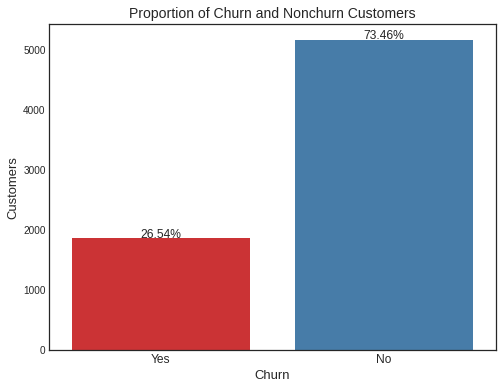

In [8]:
plt.figure(figsize=(8,6))
churn_count = data["Churn"].value_counts()
g = sns.barplot(x=churn_count.index[::-1], y=churn_count.values[::-1], palette="Set1")
total = churn_count.sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Churn and Nonchurn Customers", size=14)
plt.ylabel("Customers", size=13)
plt.xlabel("Churn", size=13)
plt.xticks(fontsize=12)
plt.show()

The above plot clearly shows a severe class imbalance in the dataset, with more than 70% of observations being of nonchurn customers.

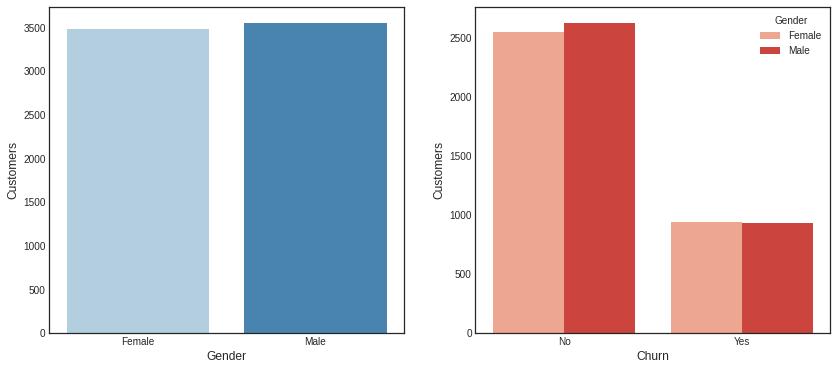

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

by_gender = data.groupby('gender')['Churn'].value_counts().reset_index(name='churn_no')
sns.countplot(x='gender', data=data[['gender']], palette='Blues', ax=ax1)
ax1.set_ylabel("Customers", size=12)
ax1.set_xlabel("Gender", size=12)
sns.barplot(x='Churn', y='churn_no', hue='gender', data=by_gender, palette="Reds", ax=ax2)
ax2.set_ylabel("Customers", size=12)
ax2.set_xlabel("Churn", size=12)
ax2.legend(title="Gender")
plt.show()

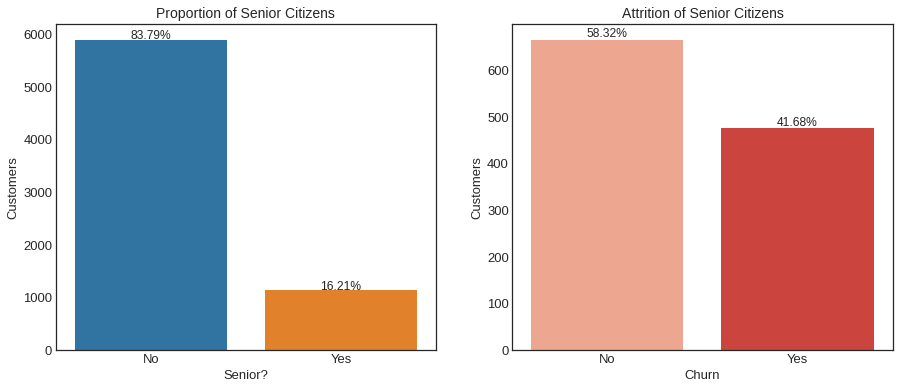

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

df_senior = data.groupby(['SeniorCitizen'])['Churn'].value_counts().reset_index(name='Customers')
df_senior = by_senior.replace({0: "No", 1: "Yes"})
senior_count = data[["SeniorCitizen"]]
senior_count = senior_count.replace({0: "No", 1: "Yes"})
df_senior_churn = df_senior[df_senior['SeniorCitizen']=='Yes']

g1 = sns.countplot(x='SeniorCitizen', data=senior_count, ax=ax1)
total = senior_count['SeniorCitizen'].value_counts().sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax1.set_ylabel("Customers", size=13)
ax1.set_xlabel("Senior?", size=13)
ax1.tick_params(labelsize=13)
ax1.set_title("Proportion of Senior Citizens", size=14)

g2 = sns.barplot(x='Churn', y='Customers', data=df_senior_churn, palette="Reds", ax=ax2)
total = df_senior_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax2.set_ylabel("Customers", size=13)
ax2.set_xlabel("Churn", size=13)
ax2.tick_params(labelsize=13)
ax2.set_title("Attrition of Senior Citizens", size=14)
plt.show()

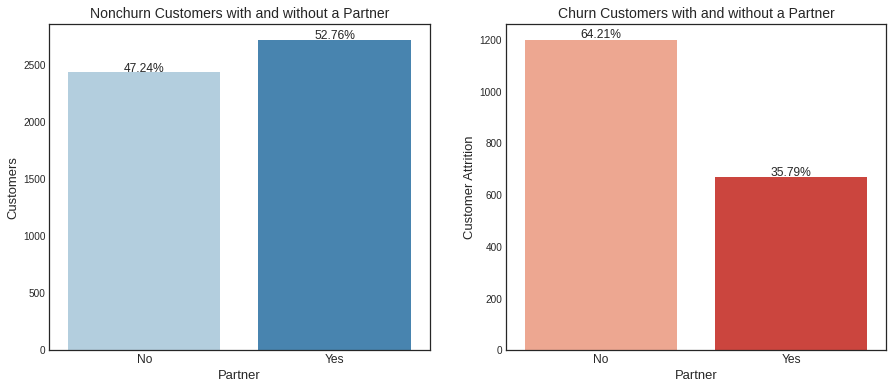

In [0]:
df_partner = data.groupby(['Partner'])['Churn'].value_counts().reset_index(name='Customers')
df_partner_nonchurn = by_partner.query("Churn=='No'")
df_partner_churn = by_partner.query("Churn=='Yes'")

plt.figure(figsize=(15, 6))

plt.subplot(121)
g1 = sns.barplot(x="Partner", y="Customers", data=df_partner_nonchurn, palette="Blues")
total = df_partner_nonchurn.Customers.sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(size=12)
plt.xlabel("Partner", size=13)
plt.ylabel("Customers", size=13)
plt.title("Nonchurn Customers with and without a Partner", size=14)
    
plt.subplot(122)
g2 = sns.barplot(x="Partner", y="Customers", data=df_partner_churn, palette="Reds")
total = df_partner_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(size=12)
plt.xlabel("Partner", size=13)
plt.ylabel("Customer Attrition", size=13)
plt.title('Churn Customers with and without a Partner', size=14)

plt.show()

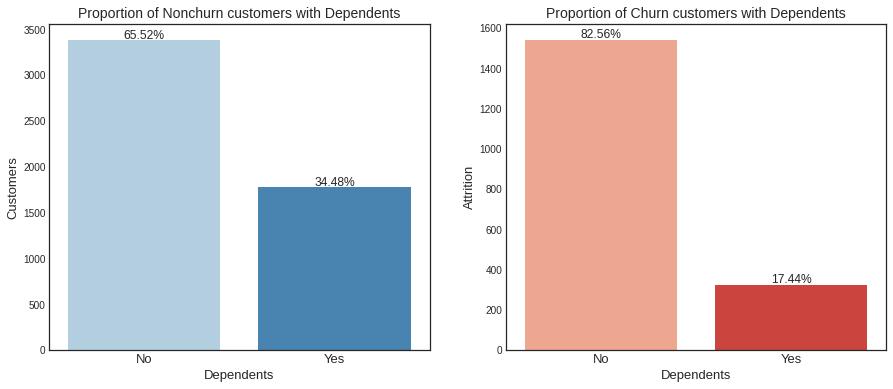

In [32]:
plt.figure(figsize=(15, 6))
df_dependets = data.groupby("Dependents")['Churn'].value_counts().reset_index(name='Customers')
df_dependets_churn = df_dependets.loc[df_dependets['Churn']=='Yes']
df_dependets_nonchurn = df_dependets.loc[df_dependets['Churn']=='No']

plt.subplot(121)
g1 = sns.barplot(x='Dependents', y='Customers', data=df_dependets_nonchurn, palette="Blues")
total = df_dependets_nonchurn.Customers.sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(fontsize=13)
plt.ylabel("Customers", fontsize=13)
plt.xlabel("Dependents", fontsize=13)
plt.title("Proportion of Nonchurn customers with Dependents", size=14)

plt.subplot(122)
g2 = sns.barplot(x='Dependents', y='Customers', data=df_dependets_churn, palette="Reds")
total = df_dependets_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel("Dependents", fontsize=13)
plt.ylabel("Attrition", fontsize=13)
plt.title("Proportion of Churn customers with Dependents", size=14)
plt.show()

# Services Contracted by Customers 

## Internet Sevices

In [0]:
df_tech_info = data.iloc[:, 5:13]
tech_info_cols = df_tech_info.columns
df_tech_info["Churn"] = data[['Churn']]

df_phone_service = df_tech_info[['PhoneService', 'MultipleLines', 'Churn']]
df_net_service = df_tech_info[['InternetService', 'Churn']]

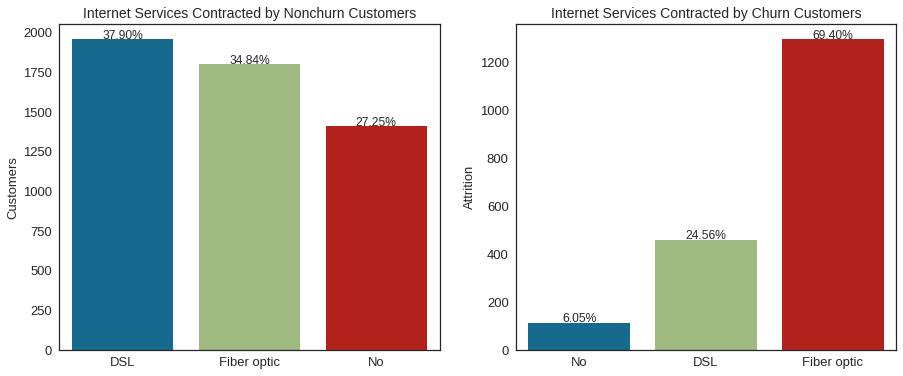

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

df_phone_service = df_tech_info[['PhoneService', 'MultipleLines', 'Churn']]
df_net_service = df_tech_info[['InternetService', 'Churn']]

g1 = sns.countplot(x='InternetService', data=df_net_service.query("Churn=='No'"), ax=ax1)
total = df_net_service.loc[df_net_service['Churn']=='No']["Churn"].value_counts()[0]
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax1.set_title("Internet Services Contracted by Nonchurn Customers", fontsize=14)
ax1.set_xlabel("")
ax1.set_ylabel("Customers", size=13)
ax1.tick_params(labelsize=13)

df_net_service = df_net_service.groupby("InternetService")["Churn"].value_counts()
df_net_churn = df_net_service.loc[:, 'Yes'].reset_index()
df_net_churn = df_net_churn.sort_values(by='Churn')

total = df_net_churn['Churn'].sum()
g2 = sns.barplot(x='InternetService', y='Churn', data=df_net_churn, ax=ax2)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total * 100),
            ha="center", fontsize=12)
ax2.set_title("Internet Services Contracted by Churn Customers", fontsize=14)
ax2.set_xlabel("")
ax2.set_ylabel("Attrition", size=13)
ax2.tick_params(labelsize=13)
plt.show()

## Phone Services

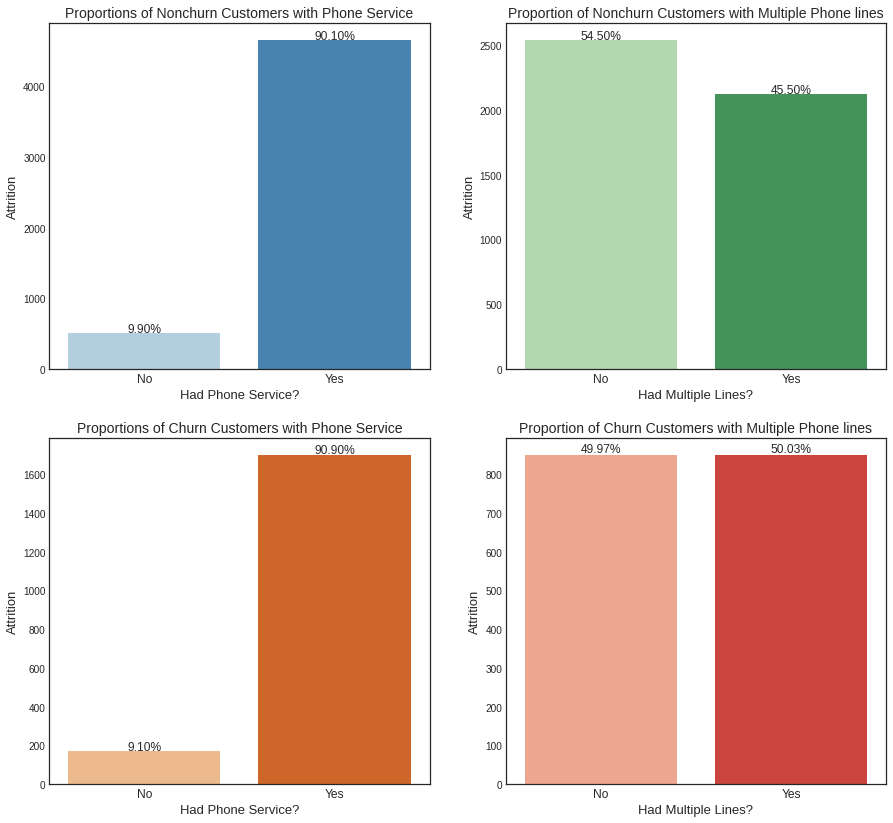

In [36]:
df_phone = df_phone_service.groupby('PhoneService')["Churn"].value_counts().reset_index(name='Customers')
df_phone_churn = df_phone.query("Churn=='Yes'")
df_phone_nonchurn = df_phone.query("Churn=='No'")

plt.figure(figsize=(15, 14))

df_multline = df_phone_service.groupby('MultipleLines')["Churn"].value_counts().reset_index(name='Customers')
df_multline_churn = df_multline.query("(MultipleLines != 'No phone service') & (Churn=='Yes')")
df_multline_nonchurn = df_multline.query("(MultipleLines != 'No phone service') & (Churn=='No')")

plt.subplot(221)
total = df_phone_nonchurn['Customers'].sum()
g1 = sns.barplot(x='PhoneService', y='Customers', data=df_phone_nonchurn, palette='Blues')
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportions of Nonchurn Customers with Phone Service", size=14)
plt.xlabel("Had Phone Service?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.subplot(222)
g2 = sns.barplot(x='MultipleLines', y='Customers', data=df_multline_nonchurn, palette='Greens')
total = df_multline_nonchurn['Customers'].sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Nonchurn Customers with Multiple Phone lines", size=14)
plt.xlabel("Had Multiple Lines?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.subplot(223)
total = df_phone_churn['Customers'].sum()
g1 = sns.barplot(x='PhoneService', y='Customers', data=df_phone_churn, palette='Oranges')
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportions of Churn Customers with Phone Service", size=14)
plt.xlabel("Had Phone Service?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.subplot(224)
g2 = sns.barplot(x='MultipleLines', y='Customers', data=df_multline_churn, palette='Reds')
total = df_multline_churn['Customers'].sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Churn Customers with Multiple Phone lines", size=14)
plt.xlabel("Had Multiple Lines?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.show()

## Additional Services

In [0]:
df_tech_info.drop(['InternetService', "PhoneService", 'MultipleLines'], axis=1, inplace=True)
df_tech_info = df_tech_info.where(df_tech_info != 'No internet service')

df_tech_churn = df_tech_info.query("Churn=='Yes'")
df_tech_nonchurn =  df_tech_info.query("Churn=='No'")

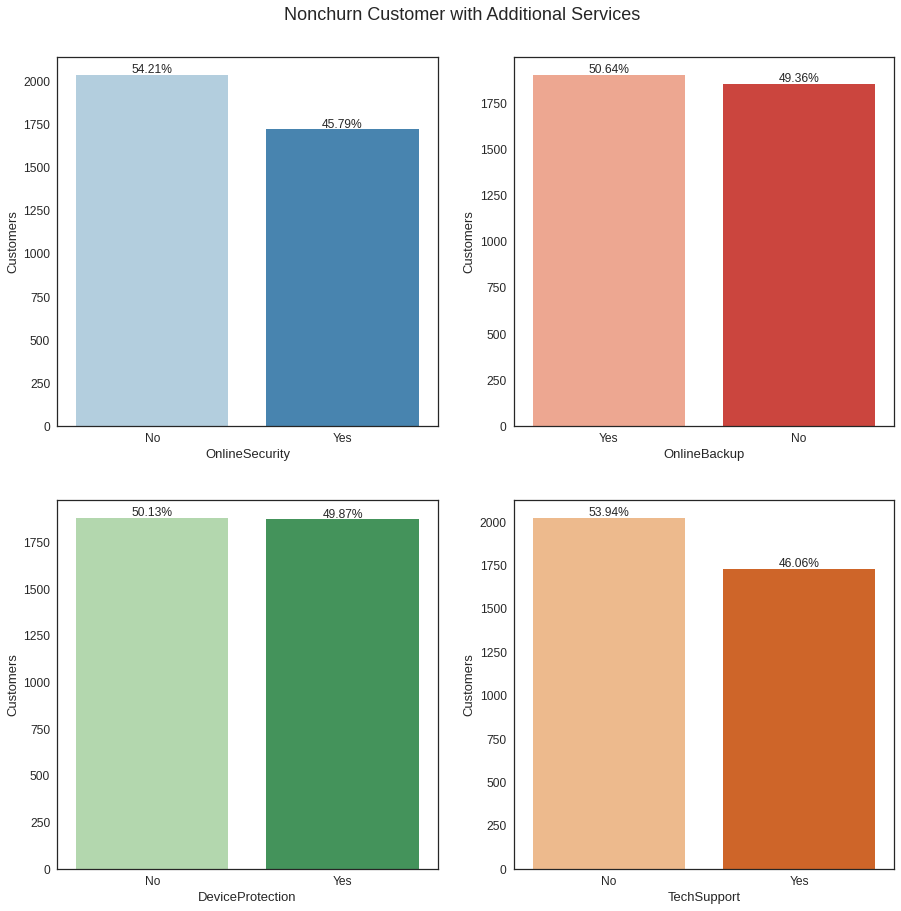

In [0]:
fig, axis = plt.subplots(2, 2, figsize=(15, 14))
fig.suptitle('Nonchurn Customer with Additional Services', size=18)
palettes = ["Blues", "Reds", "Greens", "Oranges"]
for ax, col, palette in zip(axis.flatten(), df_tech_nonchurn.columns[:-1], palettes):
    df = df_tech_nonchurn[col].value_counts().reset_index(name='Customers')
    g = sns.barplot(x='index', y='Customers', data=df, palette=palette, ax=ax)
    total = df_tech_nonchurn[col].value_counts().sum()
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
               height+10,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=12)
        ax.set_ylabel("Customers", size=13)
        ax.set_xlabel(col, size=13)
        ax.tick_params(labelsize=12)

plt.subplots_adjust(top=0.93)
plt.show()

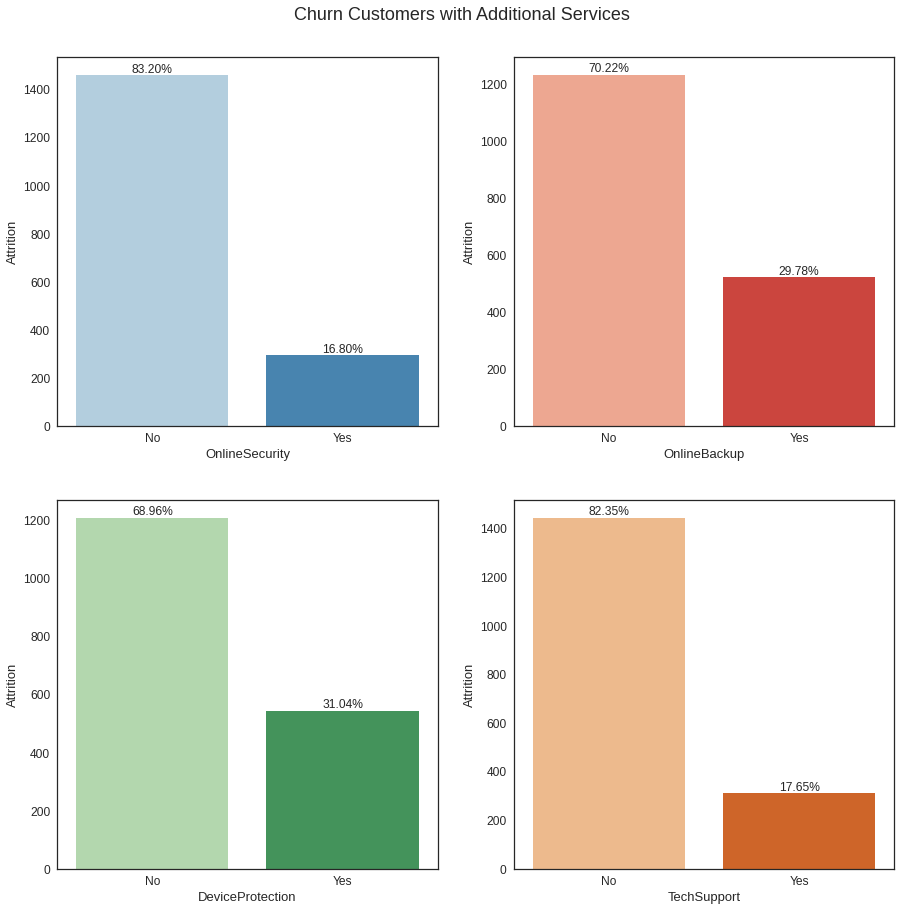

In [0]:
fig, axis = plt.subplots(2, 2, figsize=(15, 14))
fig.suptitle('Churn Customers with Additional Services', size=18)
palettes = ["Blues", "Reds", "Greens", "Oranges"]
for ax, col, palette in zip(axis.flatten(), df_tech_churn.columns[:-1], palettes):
    df = df_tech_churn[col].value_counts().reset_index(name='Customers')
    g = sns.barplot(x='index', y='Customers', data=df, palette=palette, ax=ax)
    total = df_tech_churn[col].value_counts().sum()
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
               height+10,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=12)
        ax.set_ylabel("Attrition", size=13)
        ax.set_xlabel(col, size=13)
        ax.tick_params(labelsize=12)
plt.subplots_adjust(top=0.93)
plt.show()

# Contract type and Payment Method

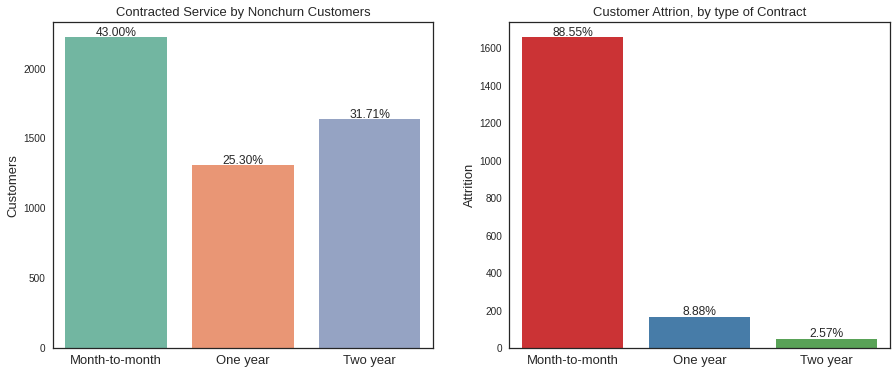

In [0]:
plt.figure(figsize=(15, 6))
df_contract = data.groupby('Contract')['Churn'].value_counts().reset_index(name="Customers")
df_contract_nonchurn = df_contract.loc[df_contract['Churn']=='No']
df_contract_churn = df_contract.loc[df_contract['Churn']=='Yes']

plt.subplot(121)
g = sns.barplot(x='Contract', y='Customers', palette='Set2', data=df_contract_nonchurn)
total = df_contract_nonchurn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total * 100),
         ha="center", fontsize=12)
plt.xlabel(None)
plt.ylabel("Customers", size=13)
plt.xticks(fontsize=13)
plt.title("Contracted Service by Nonchurn Customers", size=13)

plt.subplot(122)
g = sns.barplot(x='Contract', y='Customers', data=df_contract_churn, palette='Set1')
total = df_contract_churn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total * 100),
         ha="center", fontsize=12)   
plt.xlabel(None)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=13)
plt.title("Customer Attrion, by type of Contract", size=13)

plt.show()

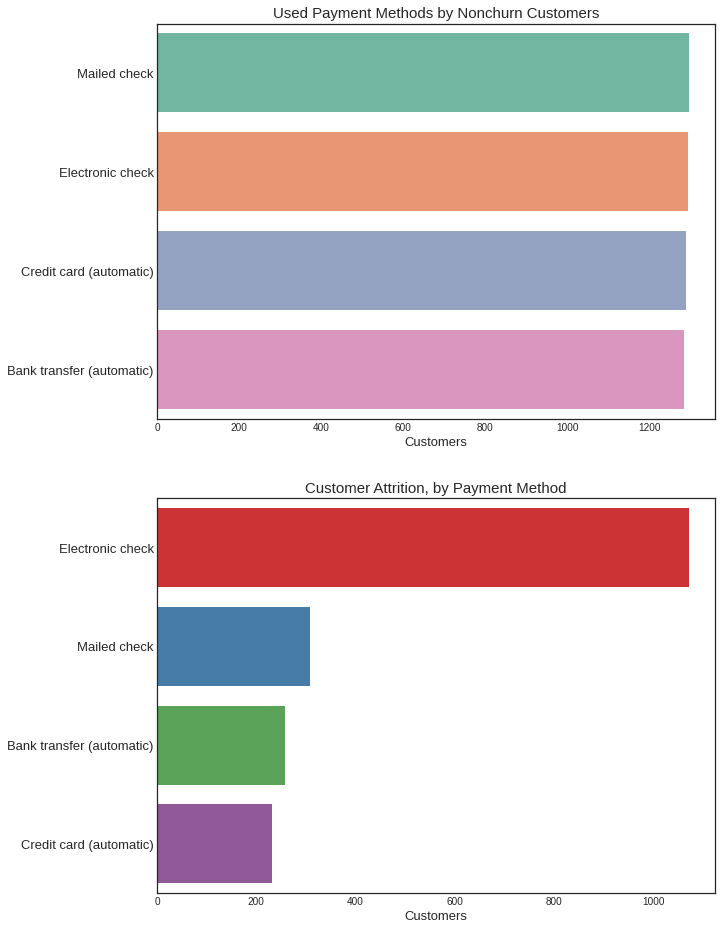

In [0]:
plt.figure(figsize=(10, 16))
df_paymethod = data.groupby("PaymentMethod")['Churn'].value_counts().reset_index(name='Customers')

df_paymethod_nonchurn = df_paymethod.query("Churn=='No'").sort_values(by='Customers', ascending=False)
df_paymethod_churn = df_paymethod.query("Churn=='Yes'").sort_values(by='Customers', ascending=False)

plt.subplot(211)
sns.barplot(x='Customers', y='PaymentMethod', palette='Set2', data=df_paymethod_nonchurn)
plt.ylabel(None)
plt.xlabel("Customers", size=13)
plt.yticks(fontsize=13)
plt.title("Used Payment Methods by Nonchurn Customers", size=15)

plt.subplot(212)
sns.barplot(x='Customers', y="PaymentMethod", palette='Set1', data=df_paymethod_churn)
plt.ylabel(None)
plt.xlabel("Customers", size=13)
plt.yticks(fontsize=13)
plt.title("Customer Attrition, by Payment Method", size=15)
plt.show()

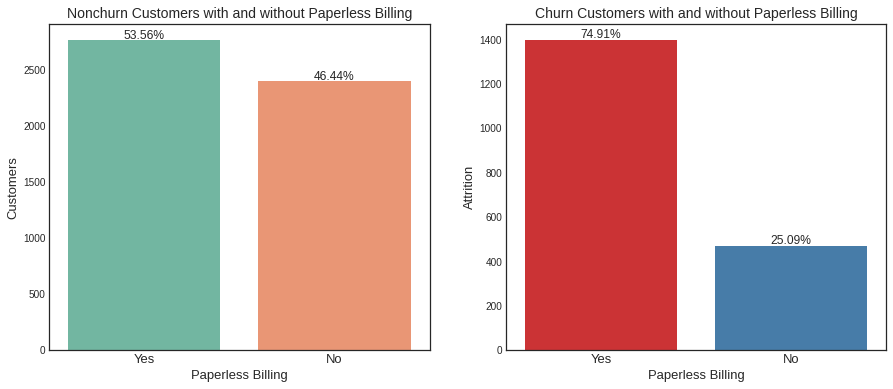

In [37]:
df_contract = data.groupby('PaperlessBilling')["Churn"].value_counts().reset_index(name='Customers')

df_billing_nonchurn = df_contract.query("Churn=='No'").sort_values(by='Customers', ascending=False)
df_billing_churn = df_contract.query("Churn=='Yes'").sort_values(by='Customers', ascending=False)

plt.figure(figsize=(15, 6))
plt.subplot(121)
g = sns.barplot(x='PaperlessBilling', y='Customers', palette='Set2', data=df_billing_nonchurn)
total = df_billing_nonchurn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.ylabel("Customers", size=13)
plt.xlabel("Paperless Billing", size=13)
plt.xticks(fontsize=13)
plt.title("Nonchurn Customers with and without Paperless Billing", size=14)

plt.subplot(122)
g = sns.barplot(x='PaperlessBilling', y='Customers', palette='Set1', data=df_billing_churn)
total = df_billing_churn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.xlabel("Paperless Billing", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=13)
plt.title("Churn Customers with and without Paperless Billing", size=14)
plt.show()

# Tenure of Customers

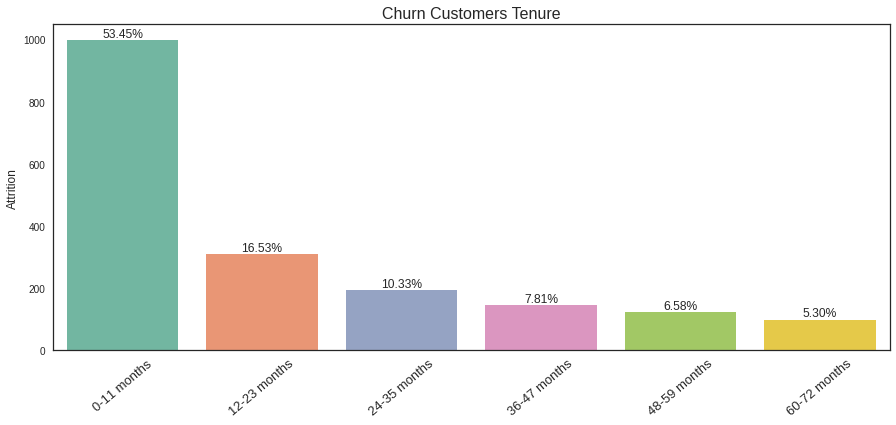

In [0]:
df_tenure = data.groupby('tenure_time')["Churn"].value_counts().reset_index(name="Customers")
df_tenure_churn = df_tenure.query("Churn=='Yes'")
plt.figure(figsize=(15, 6))
g = sns.barplot(x="tenure_time", y='Customers', data=df_tenure_churn, palette="Set2")
total = df_tenure_churn.Customers.sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.xticks(rotation=40, size=13)
plt.ylabel("Attrition", size=12)
plt.title("Churn Customers Tenure", size=16)
plt.xlabel(None)
plt.show()

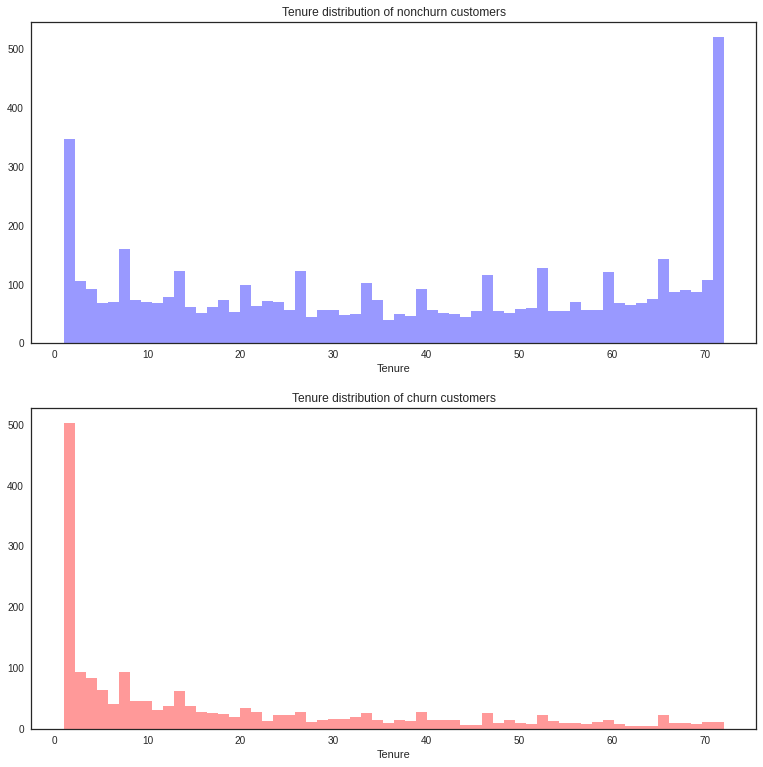

In [0]:
plt.figure(figsize=(13, 13))
plt.subplot(211)
sns.distplot(data.query("Churn=='No'")["tenure"], bins=60, kde=False, color='blue')
plt.title("Tenure distribution of nonchurn customers")
plt.xlabel("Tenure")
plt.subplot(212)
sns.distplot(data.query("Churn=='Yes'")["tenure"], bins=60, kde=False, color='red')
plt.title('Tenure distribution of churn customers')
plt.xlabel("Tenure")
plt.show()

# Monthly Charges Distribution

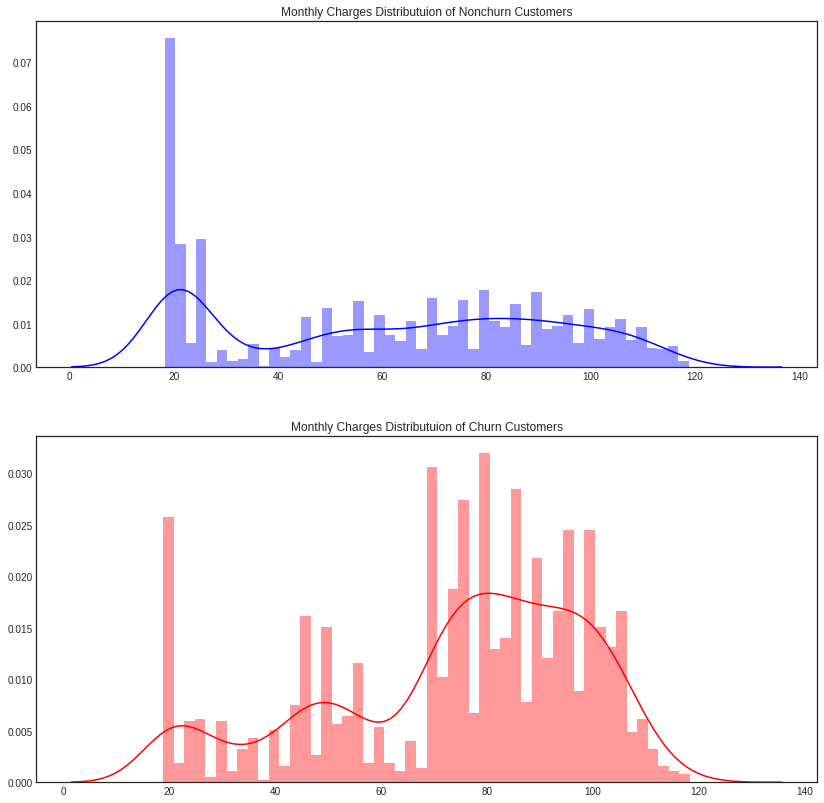

In [0]:
df_charge_nonchurn = data[["MonthlyCharges", 'Churn']].query("Churn=='No'")[['MonthlyCharges']]
df_charge_churn = data[["MonthlyCharges", 'Churn']].query("Churn=='Yes'")[['MonthlyCharges']]

plt.figure(figsize=(14, 14))

plt.subplot(211)
sns.distplot(df_charge_nonchurn , bins=50, kde=True, color='blue')
plt.title("Monthly Charges Distributuion of Nonchurn Customers")

plt.subplot(212)
sns.distplot(df_charge_churn , bins=50, kde=True, color='red')
plt.title("Monthly Charges Distributuion of Churn Customers")

plt.show()

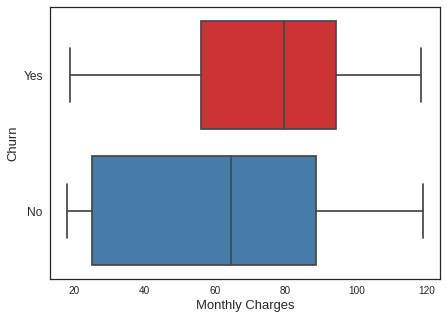

In [0]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='MonthlyCharges', y='Churn', data=data, order=["Yes", "No"], palette="Set1")
plt.xlabel('Monthly Charges', size=13)
plt.ylabel('Churn', size=13)
plt.yticks(size=12)
plt.show()

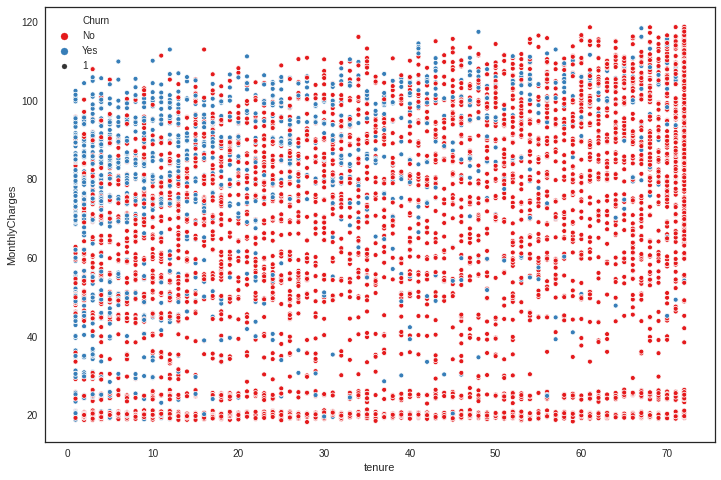

In [0]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tenure', 
                y='MonthlyCharges', 
                hue="Churn", 
                data=data, 
                size=1,
                palette='Set1')
plt.show()    

# Data Pre-processig

## Enconding binary features

In [77]:
from sklearn.preprocessing import LabelEncoder
binary_encoder = LabelEncoder()
binary_col = data.nunique()[data.nunique() == 2].index
Feature_binary = data[binary_col]
Feature_binary = Feature_binary.apply(binary_encoder.fit_transform)
Feature_binary.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,0,0,1,0,0,1,0
1,1,0,0,0,1,0,0
2,1,0,0,0,1,1,1
3,1,0,0,0,0,0,0
4,0,0,0,0,1,1,1


## One-hot encoding categorical features

In [78]:
multiclass_col = data.nunique()[(data.nunique() > 2) & (data.nunique() <= 6)].index
Feature_multiclass = data[multiclass_col]
Feature_multiclass = pd.get_dummies(Feature_multiclass)
Feature_multiclass.head()

,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_time_0-11 months,tenure_time_12-23 months,tenure_time_24-35 months,tenure_time_36-47 months,tenure_time_48-59 months,tenure_time_60-72 months
0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
2,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
3,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0


## Creating data frame for numerical features

In [79]:
numeric_col = data.drop('tenure', axis=1).nunique()[data.nunique() > 6].index
Feature_numeric = data[numeric_col]
Feature_numeric.head()

,MonthlyCharges,TotalCharges
0,29.85,29.85
1,56.95,1889.50
2,53.85,108.15
3,42.30,1840.75
4,70.70,151.65


## Merging data frames

In [80]:
merged_df = pd.merge(Feature_numeric, Feature_multiclass, left_index=True, right_index=True)
df_feature = pd.merge(merged_df, Feature_binary, right_index=True, left_index=True)
df_feature.head()

,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_time_0-11 months,tenure_time_12-23 months,tenure_time_24-35 months,tenure_time_36-47 months,tenure_time_48-59 months,tenure_time_60-72 months,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,29.85,29.85,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,56.95,1889.50,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
2,53.85,108.15,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1
3,42.30,1840.75,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,70.70,151.65,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1


## Loading the data as numpy arrays

In [0]:
X_data, y_true = df_feature.iloc[:, :-1].values, df_feature['Churn'].values.astype(int)

# Over-sampling with SMOTE

In [0]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_data, y_true)

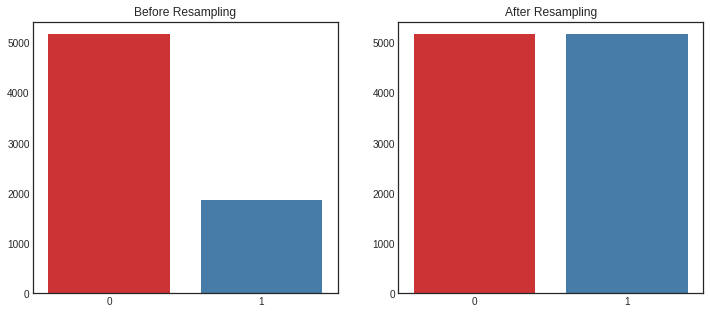

In [89]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.barplot(x=[0, 1], y=[X_data[y_true==0].shape[0], X_data[y_true==1].shape[0]], palette="Set1")
plt.title("Before Resampling")
plt.subplot(122)
sns.barplot(x=[0, 1], y=[X_resampled[y_resampled==0].shape[0], X_resampled[y_resampled==1].shape[0]], palette="Set1")
plt.title("After Resampling")
plt.show()

# Model Fitting

In [0]:
# Splitting the data into a training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=111)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [93]:
print("Train size: {} | Test size: {}".format(X_train.shape[0], X_test.shape[0]))

Train size: 7744 | Test size: 2582


## Tree-based Models

### Random Forest

In [100]:
RF_model = RandomForestClassifier(
    criterion='gini',
    n_estimators=100,
    max_depth=10
)

RF_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### XGBoost

In [213]:
xgboost = xgb.XGBClassifier(
    objective="binary:logistic", 
    max_depth=7,
    booster='gbtree',
    learning_rate=0.1,
    n_estimators=100,
    num_round=100
  )

xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_round=100, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

### LightGBM

In [215]:
lgb_model = lbg.LGBMClassifier(
    max_depth=30,
    min_data_in_leaf=15,
    min_child_samples=30,
    num_leaves=50,
    n_estimators=100
  )
lgb_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=30,
               min_child_samples=30, min_child_weight=0.001,
               min_data_in_leaf=15, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=50, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### Catboost

In [216]:
cb_model = cb.CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.01,
    l2_leaf_reg=3,
    bagging_temperature=1,
    verbose=0,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)

cb_model.fit(X_train, y_train)

## Testing other classification algorithms

### KNeighbors

In [124]:
# Finding the best k
Ks = 16
acc = []
for k in range(1, Ks):
    knn = kNN(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    knn_yhat = knn.predict(X_test)
    acc.append((k, np.mean(knn_yhat==y_test)))
acc

[(1, 0.8408210689388071),
 (2, 0.8171959721146398),
 (3, 0.8075135553834237),
 (4, 0.8005422153369481),
 (5, 0.789697908597986),
 (6, 0.7889233152594888),
 (7, 0.7943454686289698),
 (8, 0.7951200619674671),
 (9, 0.7877614252517429),
 (10, 0.7920216886134779),
 (11, 0.7811773818745159),
 (12, 0.7862122385747483),
 (13, 0.7780790085205267),
 (14, 0.7823392718822618),
 (15, 0.78001549186677)]

In [126]:
# Train with k=1
knn = kNN(n_neighbors=1, metric='minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### SVM

In [135]:
svm = SVC(kernel='rbf', C=5.0, random_state=1)
svm.fit(X_train, y_train)

SVC(C=5.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

### Logistic Regression

In [145]:
lr = LogisticRegression(penalty='l2', C=4.0,
                        random_state=1,
                        max_iter=500)

lr.fit(X_train, y_train)

LogisticRegression(C=4.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Naive Bayes

In [154]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

# Model Evaluation and Results

In [218]:
models = [xgboost, lgb_model, cb_model, RF_model, knn, svm, lr, gnb]
f1score = [f1_score(y_test, model.predict(X_test)) for model in models]
rec = [recall_score(y_test, model.predict(X_test)) for model in models]
pre = [precision_score(y_test, model.predict(X_test)) for model in models]
acc = [accuracy_score(y_test, model.predict(X_test)) for model in models]
cohen_kappa = [cohen_kappa_score(y_test, model.predict(X_test)) for model in models]
roc_auc = [roc_auc_score(y_test, model.predict(X_test)) for model in models]

df_results = pd.DataFrame({"Algorithm" : [type(model).__name__ for model in models],
                           "Accuracy" : acc,
                           "Precision" : pre,
                           "Recall" : rec,
                           "F1-Score" : f1score,
                           "ROC_AUC" : roc_auc,
                           "Cohen's Kappa": cohen_kappa})

pd.options.display.float_format = '{:,.2f}'.format
df_results

,Algorithm,Accuracy,Precision,Recall,F1-Score,ROC_AUC,Cohen's Kappa
0,XGBClassifier,0.87,0.90,0.84,0.87,0.87,0.73
1,LGBMClassifier,0.86,0.89,0.83,0.86,0.86,0.72
2,CatBoostClassifier,0.87,0.90,0.85,0.87,0.87,0.74
3,RandomForestClassifier,0.86,0.87,0.87,0.87,0.86,0.73
4,KNeighborsClassifier,0.84,0.80,0.92,0.86,0.84,0.68
5,SVC,0.85,0.86,0.84,0.85,0.85,0.69
6,LogisticRegression,0.77,0.77,0.80,0.79,0.77,0.55
7,GaussianNB,0.77,0.74,0.86,0.79,0.76,0.53


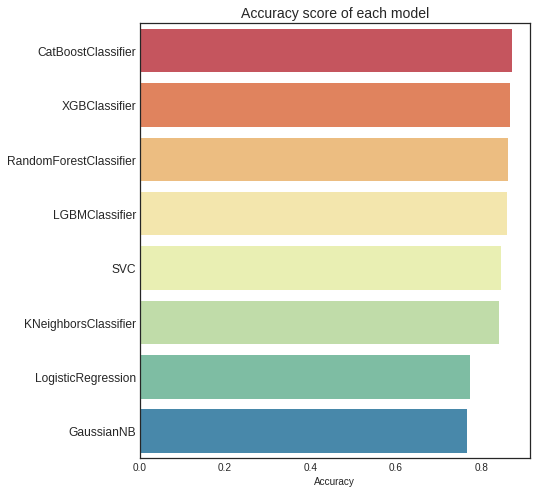

In [219]:
plt.figure(figsize=(7, 8))
sns.barplot(x="Accuracy", 
            y='Algorithm', 
            data=df_results.sort_values(by='Accuracy', ascending=False), 
            palette="Spectral")
plt.ylabel(None)
plt.yticks(size=12)
plt.title("Accuracy score of each model", size=14)
plt.show()

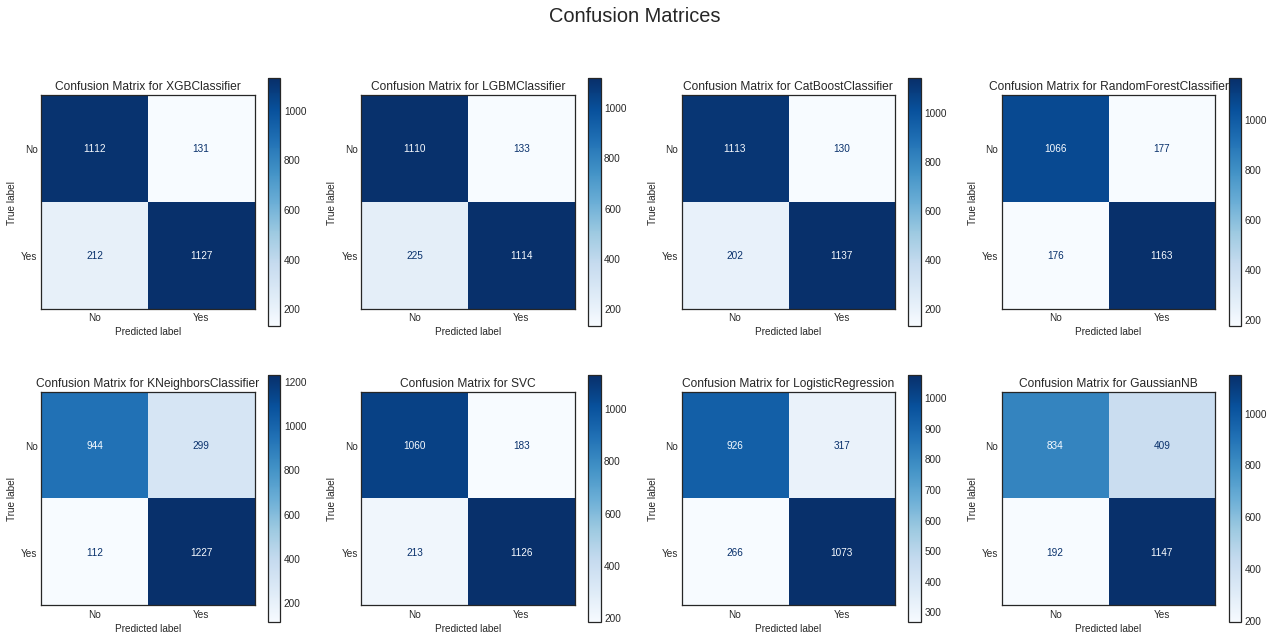

In [222]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle("Confusion Matrices", size=20)
for model, axes in zip(models, ax.flatten()):
  cm = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=['No', 'Yes'],
                             cmap="Blues",
                             normalize=None,
                             values_format='.10g',
                             ax=axes)
  cm.ax_.set_title("Confusion Matrix for {}".format(type(model).__name__))
plt.show()

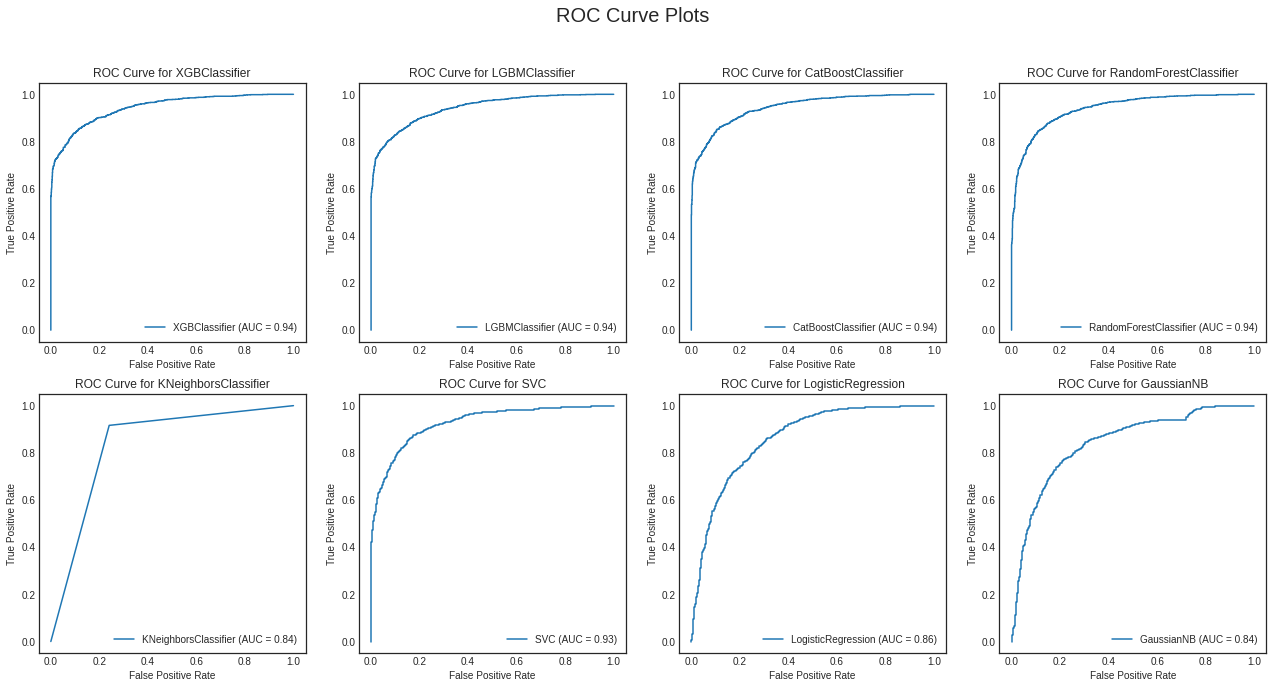

In [221]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10.5))
fig.suptitle("ROC Curve Plots", size=20)
for model, axes in zip(models, ax.flatten()):
  rocc = plot_roc_curve(model, X_test, y_test, ax=axes)
  rocc.ax_.set_title("ROC Curve for {}".format(type(model).__name__))
plt.show()

In [0]:
pconn.close()

True